In [1]:
#A machine learning pipeline is an ordered sequence of data preprocessing and modeling steps
#An outlier is a data point that is significantly different from the rest of the dataset and can distort statistical analyses or model training
#Capping is the process of limiting a variable’s values to a maximum and/or minimum threshold to reduce the impact of outliers

import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = "datasets/housing"
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + "/housing.tgz"

if not os.path.isdir(HOUSING_PATH):
    os.makedirs(HOUSING_PATH)

tgz_path = os.path.join(HOUSING_PATH, "housing.tgz")
print("Downloading from:", HOUSING_URL)
urllib.request.urlretrieve(HOUSING_URL, tgz_path)

print("Download complete. Extracting...")
housing_tgz = tarfile.open(tgz_path)
housing_tgz.extractall(path=HOUSING_PATH)
housing_tgz.close()

print("Extraction complete. Files in directory:", os.listdir(HOUSING_PATH))


Download complete. Extracting...
Extraction complete. Files in directory: ['housing.csv', 'housing.tgz']


In [2]:
import pandas as pd
def load_housing_data(housing_path=HOUSING_PATH):
 csv_path = os.path.join(housing_path, "housing.csv")
 return pd.read_csv(csv_path)


In [3]:
housing=load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
#how many distinct values we have in the ocean proximity column
housing["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [6]:
#describe the numerical columns 
#a percentile(%25..etc) indicates the value below which a given percentage
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


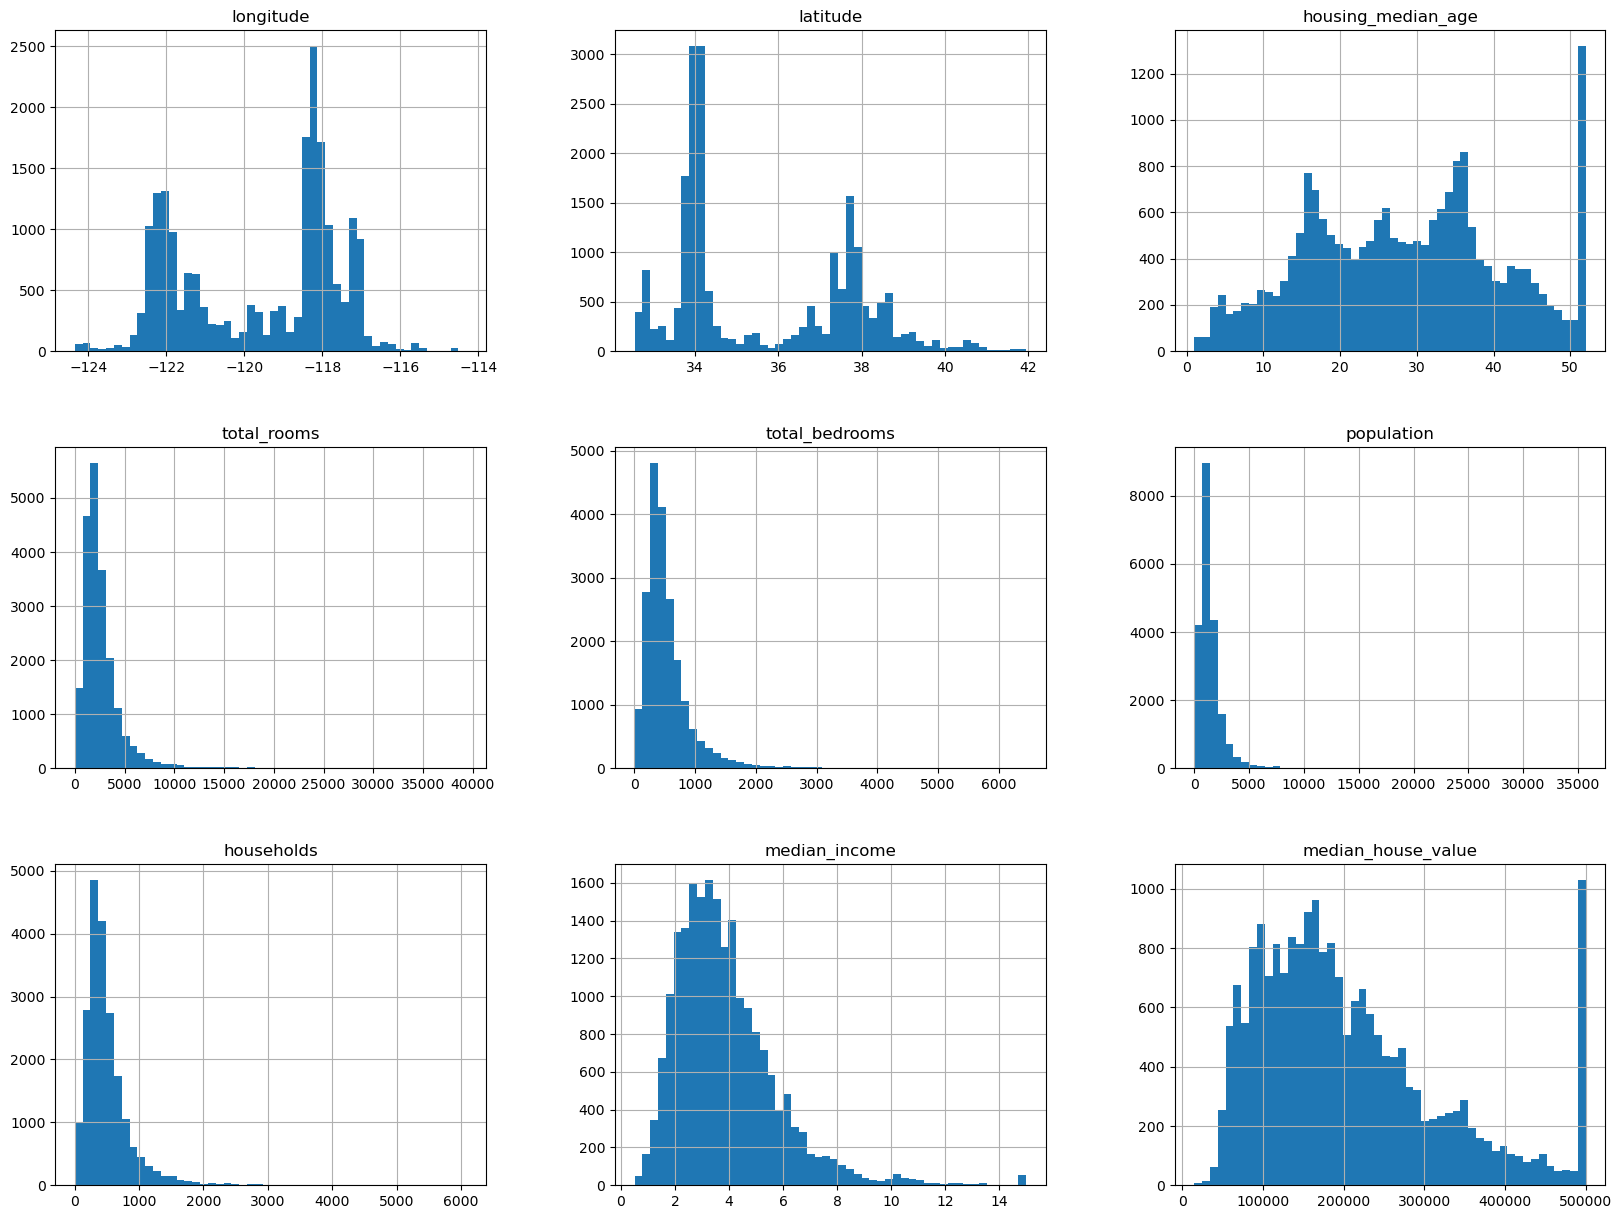

In [7]:
#create a histogram for each numerical attribute
import matplotlib.pyplot as plt
housing.hist(bins=50,figsize=(20,15))
plt.show()

In [8]:
import numpy as np
import hashlib
def test_set_check(identifier, test_ratio, hash):
 return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio
def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
 ids = data[id_column]
 in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
 return data.loc[~in_test_set], data.loc[in_test_set]

In [9]:
 #Create a stable ID using longitude and latitude
housing_with_id = housing.copy()
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")


In [10]:
#new column income_cat which groups median income into discrete bins (1.0, 2.0, 3.0, etc.)
housing["income_cat"]= np.ceil(housing["median_income"]/1.5)
#If income_cat < 5, keep it. Otherwise, set it to 5.0
housing.loc[housing["income_cat"] > 5, "income_cat"] = 5.0


In [11]:
#stratification ensures that the train and test sets have the same proportions of income categories (income_cat) as the original dataset
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
 strat_train_set = housing.loc[train_index]
 strat_test_set = housing.loc[test_index]


In [12]:
#income category proportions in the full housing dataset
(housing["income_cat"].value_counts() / len(housing))*100

income_cat
3.0    35.058140
2.0    31.884690
4.0    17.630814
5.0    11.443798
1.0     3.982558
Name: count, dtype: float64

In [13]:
for set in (strat_train_set, strat_test_set):
 set.drop(["income_cat"], axis=1, inplace=True)


In [14]:
housing = strat_train_set.copy()


<Axes: xlabel='longitude', ylabel='latitude'>

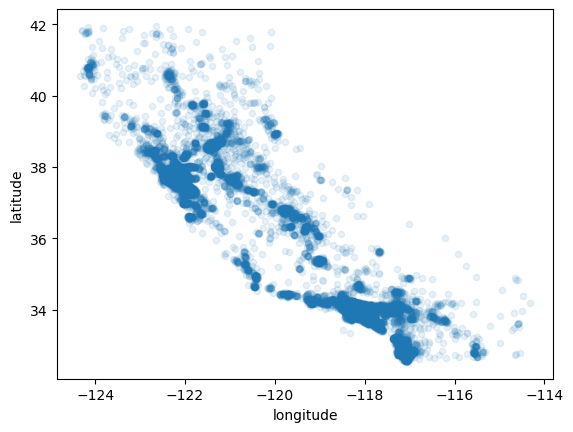

In [15]:
#alpha ranges from 0 (fully transparent) to 1 (fully opaque)alpha=0.1 makes the points 90% transparent to visualize dense regions: areas with overlapping points appear darker
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)


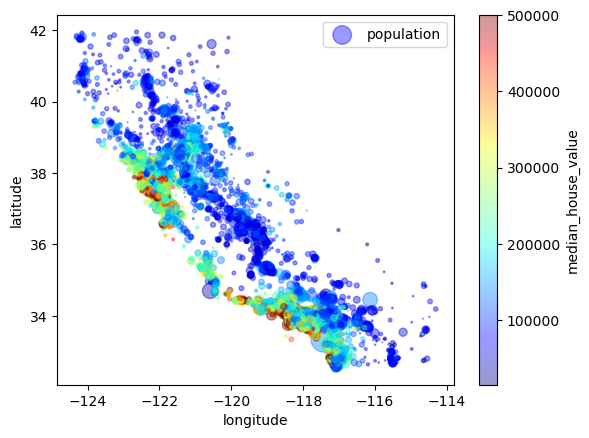

In [16]:
#Controls size of each point=>Bigger circle = larger population in that district.
#c Sets color of each point based on the median house value
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
 s=housing["population"]/100, label="population",
 c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend()

In [17]:
# show correlation between median_house_value and each column , 0 means no correlation
corr_matrix = housing.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)


median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

array([[<Axes: xlabel='median_house_value', ylabel='median_house_value'>,
        <Axes: xlabel='median_income', ylabel='median_house_value'>,
        <Axes: xlabel='total_rooms', ylabel='median_house_value'>,
        <Axes: xlabel='housing_median_age', ylabel='median_house_value'>],
       [<Axes: xlabel='median_house_value', ylabel='median_income'>,
        <Axes: xlabel='median_income', ylabel='median_income'>,
        <Axes: xlabel='total_rooms', ylabel='median_income'>,
        <Axes: xlabel='housing_median_age', ylabel='median_income'>],
       [<Axes: xlabel='median_house_value', ylabel='total_rooms'>,
        <Axes: xlabel='median_income', ylabel='total_rooms'>,
        <Axes: xlabel='total_rooms', ylabel='total_rooms'>,
        <Axes: xlabel='housing_median_age', ylabel='total_rooms'>],
       [<Axes: xlabel='median_house_value', ylabel='housing_median_age'>,
        <Axes: xlabel='median_income', ylabel='housing_median_age'>,
        <Axes: xlabel='total_rooms', ylabel='housi

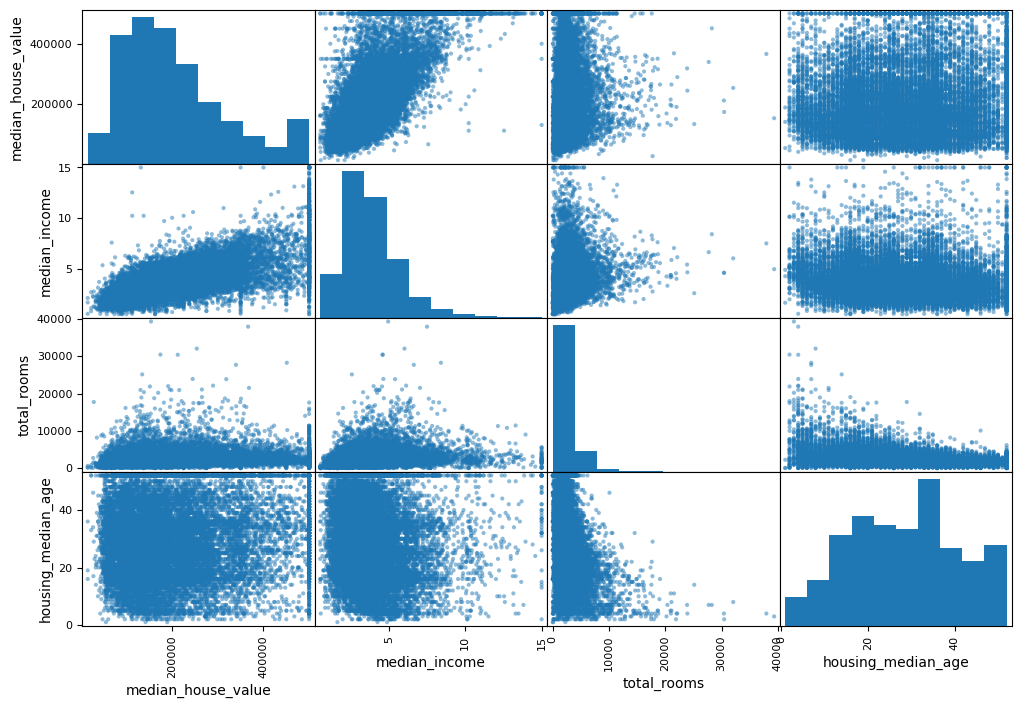

In [18]:
from pandas.plotting import scatter_matrix
attributes = ["median_house_value", "median_income", "total_rooms",
 "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))


<Axes: xlabel='median_income', ylabel='median_house_value'>

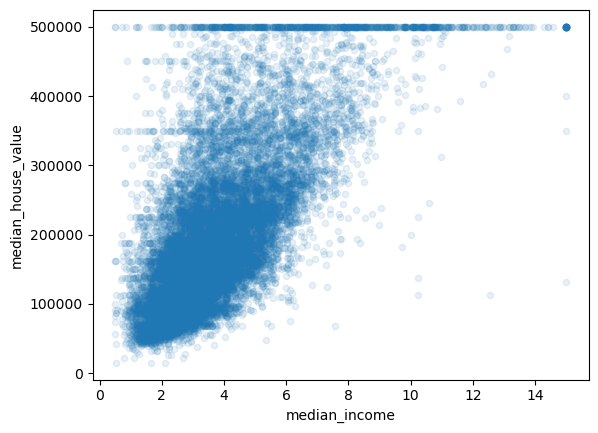

In [19]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
 alpha=0.1)

In [20]:
# manual feature engineering 
#housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
#housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
#housing["population_per_household"]=housing["population"]/housing["households"]

In [21]:
#corr_matrix = housing.corr(numeric_only=True)
#corr_matrix["median_house_value"].sort_values(ascending=False)

In [22]:
# drop returns a new DataFrame (housing) without the "median_house_value"/label column
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [23]:
#only numerical columns
housing_num = housing.drop("ocean_proximity", axis=1)


In [24]:
#transform categorial columns to numerical columns and encode them
# label encoding is not suitable cuz the model can interpret that two nearby values are more similar than two distant values(1>4)
#from sklearn.preprocessing import LabelEncoder
#encoder = LabelEncoder()
housing_cat=housing[["ocean_proximity"]]
#housing_cat_encoded=encoder.fit_transform(housing_cat)
#housing_cat_encoded

In [25]:
#one hot encoding gives either 0 or 1 for each column
#from sklearn.preprocessing import OneHotEncoder
#encoder = OneHotEncoder()
#housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
#housing_cat_1hot

In [26]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np

# Define column indexes (based on the order of columns in the input array)
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):  # optional parameter to add bedrooms_per_room
        self.add_bedrooms_per_room = add_bedrooms_per_room

    def fit(self, X, y=None):
        # No fitting necessary for this transformer, just return self
        return self

    def transform(self, X, y=None):
        # Compute new features using existing columns
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]

        if self.add_bedrooms_per_room:
            # Optionally add bedrooms_per_room as a feature
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            # Append all new features as new columns to the original array
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            # Only append the first two new features
            return np.c_[X, rooms_per_household, population_per_household]

# Create transformer instance with or without the optional feature
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)

# Apply the transformer to the housing data (as a NumPy array)
housing_extra_attribs = attr_adder.transform(housing.values)



In [27]:
#pipeline for numerical columns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer  # ✅ use this instead of Imputer

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

housing_num_tr = num_pipeline.fit_transform(housing_num)


In [28]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),  # fill missing values
    ('onehot', OneHotEncoder(handle_unknown='ignore'))      # convert to one-hot vectors
])

housing_cat_tr = cat_pipeline.fit_transform(housing_cat)


In [29]:
from sklearn.compose import ColumnTransformer

# Define which columns are numerical and categorical
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

# Combine both pipelines
full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),  # numeric pipeline
    ("cat", cat_pipeline, cat_attribs),  # categorical pipeline
])

# Apply to the full housing dataset
housing_prepared = full_pipeline.fit_transform(housing)


In [44]:
# Reconstruct column names
num_attr_names = num_attribs.copy()
if num_pipeline.named_steps['attribs_adder'].add_bedrooms_per_room:
    num_attr_names += ['rooms_per_household', 'population_per_household', 'bedrooms_per_room']
else:
    num_attr_names += ['rooms_per_household', 'population_per_household']

cat_encoder = cat_pipeline.named_steps["onehot"]
cat_onehot_attribs = list(cat_encoder.get_feature_names_out(cat_attribs))

full_feature_names = num_attr_names + cat_onehot_attribs

# Create a DataFrame from the preprocessed NumPy array
housing_prepared_df = pd.DataFrame(housing_prepared, columns=full_feature_names)

# Optional: Save cleaned dataset to CSV
housing_prepared_df.to_csv("housing_cleaned.csv", index=False)


In [30]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)


LinearRegression()

In [31]:
>>> some_data = housing.iloc[:5]
>>> some_labels = housing_labels.iloc[:5]
>>> some_data_prepared = full_pipeline.transform(some_data)
>>> print("Predictions:\t", lin_reg.predict(some_data_prepared))
>>> print("Labels:\t\t", list(some_labels))

Predictions:	 [ 85657.90192014 305492.60737488 152056.46122456 186095.70946094
 244550.67966089]
Labels:		 [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


In [32]:
>>> from sklearn.metrics import mean_squared_error
>>> housing_predictions = lin_reg.predict(housing_prepared)
>>> lin_mse = mean_squared_error(housing_labels, housing_predictions)
>>> lin_rmse = np.sqrt(lin_mse)
#rmse very high => underfitting
>>> print(float(lin_rmse))

68627.87390018745


In [33]:
#we try another model perfect for non linear relationships
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)


DecisionTreeRegressor()

In [34]:
# overfitting
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
print(float(tree_rmse))

0.0


In [35]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "max_depth": [10, 20, None],
    "min_samples_split": [2, 10, 20],
    "min_samples_leaf": [1, 5, 10]
}

grid_search = GridSearchCV(tree_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [10, 20, None],
                         'min_samples_leaf': [1, 5, 10],
                         'min_samples_split': [2, 10, 20]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [36]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
 scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)


In [37]:
#results shows that decision tree is performing worse than linear regression
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
display_scores(rmse_scores)

Scores: [72025.74696053 70911.93951841 68991.52087874 73077.41112851
 69712.2484446  77777.86593244 71051.69996819 73248.37767914
 70011.75362719 71274.09059811]
Mean: 71808.26547358555
Standard deviation: 2378.739338087934


In [38]:
# 4. View best model and performance
#GridSearch did improve the Decision Tree significantly.It outperformed Linear Regression.
grid_search.best_params_
grid_search.best_estimator_
np.sqrt(-grid_search.best_score_)

np.float64(60035.41947856126)

In [39]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(housing_prepared, housing_labels)


RandomForestRegressor(random_state=42)

In [40]:
from sklearn.model_selection import cross_val_score
import numpy as np

forest_scores = cross_val_score(
    forest_reg, housing_prepared, housing_labels,
    scoring="neg_mean_squared_error", cv=10
)
forest_rmse_scores = np.sqrt(-forest_scores)


In [41]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(forest_rmse_scores)


Scores: [51559.63379638 48737.57100062 47210.51269766 51875.21247297
 47577.50470123 51863.27467888 52746.34645573 50065.1762751
 48664.66818196 54055.90894609]
Mean: 50435.58092066179
Standard deviation: 2203.3381412764606


In [42]:
from sklearn.model_selection import GridSearchCV

param_grid_forest = {
    "n_estimators": [30, 50, 100],
    "max_features": [6, 8, 10],
}

grid_search_forest = GridSearchCV(
    forest_reg, param_grid_forest,
    cv=5, scoring="neg_mean_squared_error",
    return_train_score=True
)
grid_search_forest.fit(housing_prepared, housing_labels)
best_forest = grid_search_forest.best_estimator_


In [43]:
from sklearn.model_selection import train_test_split

# Assuming housing and housing_labels were not yet split
housing_train, housing_test, labels_train, labels_test = train_test_split(
    housing, housing_labels, test_size=0.2, random_state=42)

# Prepare the test data using the full_pipeline
housing_test_prepared = full_pipeline.transform(housing_test)

# Predict and evaluate
final_predictions = best_forest.predict(housing_test_prepared)
final_mse = mean_squared_error(labels_test, final_predictions)
final_rmse = np.sqrt(final_mse)
print("Final RMSE on Test Set:", final_rmse)


Final RMSE on Test Set: 18026.579622883604
